In [1]:
import os
import re
import cv2
from cv2 import VideoCapture
import numpy as np
from tqdm.notebook import tqdm, trange
import matplotlib.pyplot as plt
from typing import List, Any, Union, Tuple
import os
import math
import random
import logging

In [2]:
def video2frames(vid_path: str, save_path: str) -> None:
    """Convert videos to frame and save frames.

    Args:
        vid_path: path to video
        save_path: path to save frames to
    """
    assert save_path[-1] == "/", f"Requires a directory, {save_path} must end in '/'"
    if not os.path.exists(save_path):
        os.makedirs(save_path)

    vidcap = VideoCapture(vid_path)
    success, image = vidcap.read()
    count = 0
    while success:
        # save frame as JPEG file
        cv2.imwrite(save_path + f"{count}.jpg", image)
        success, image = vidcap.read()
        count += 1
    print(f"Saved {count} frames to {save_path}.")
    vidcap.release()


In [3]:
# convert bfmc_2020 videos to frames
vid_paths = [
    # "./data/Records/bfmc2020_online_1.avi",
    # "./data/Records/bfmc2020_online_2.avi",
    # "./data/Records/bfmc2020_online_3.avi",
    # "./data/Records/bfmc2020_online_1.avi",
]

paths = []
path = f"./data/bfmc2020/frames_3/"  # edit this
paths.append(path)


In [4]:
for i, v_path in enumerate(vid_paths):
    paths.append(path)
    video2frames(v_path, path)
path = f"./data/bfmc2020/frames_3/"  # edit this


In [5]:
def import_images(path: str) -> List[np.ndarray]:
    """Import all the images of a given directory path and return an array of images

    Args:
        path:(str) path to dir (Make sure path ends in a /)

    Returns:List[np.ndarray] List of images.

    """
    assert path[-1] == "/", f"Requires a directory, {path} must end in a '/'"

    # get file names of frames
    col_frames = os.listdir(path)
    col_frames.sort(key=lambda f: int(re.sub("\D", "", f)))

    # load frames
    col_images = []
    for i in tqdm(col_frames):
        img = cv2.imread(path + i)
        col_images.append(img)
    return col_images


path = paths[0]
col_images = import_images(path)
len(col_images)


  0%|          | 0/2163 [00:00<?, ?it/s]

2163

In [38]:
# col_images[2]


889


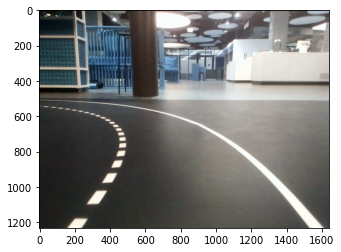

In [39]:
idx = random.randint(0, 2163)
print(idx)
idx = 840
plt.imshow(col_images[idx])


# Processing for Image


In [40]:
def processImage(
    inpImage: np.ndarray,
) -> Tuple[np.ndarray, np.ndarray, np.ndarray, np.ndarray, np.ndarray]:
    """Apply preprocessing to the input image

    Args:
        image: (np.ndarray) imput image

    Returns:

    """

    # Apply HLS color filtering to filter out white lane lines
    hls = cv2.cvtColor(inpImage, cv2.COLOR_BGR2HLS)
    lower_white = np.array([180, 180, 180])
    upper_white = np.array([255, 255, 255])
    mask = cv2.inRange(inpImage, lower_white, upper_white)
    hls_result = cv2.bitwise_and(inpImage, inpImage, mask=mask)

    # Convert image to grayscale, apply threshold, blur & extract edges
    gray = cv2.cvtColor(hls_result, cv2.COLOR_BGR2GRAY)
    thresh = cv2.adaptiveThreshold(
        gray,
        255,
        cv2.ADAPTIVE_THRESH_GAUSSIAN_C,
        cv2.THRESH_BINARY_INV,
        21,
        4,
    )
    # ret, thresh = cv2.threshold(gray, 160, 255, cv2.THRESH_BINARY)
    blur = cv2.GaussianBlur(thresh, (7, 7), 0)
    canny = cv2.Canny(blur, 40, 60)

    # Display the processed images
    # plt.imshow("Image", inpImage)
    # plt.imshow("HLS Filtered", hls_result)
    # plt.imshow("Grayscale", gray)
    # plt.imshow("Thresholded", thresh)
    # plt.imshow("Blurred", blur)
    # plt.imshow("Canny Edges", canny)

    return hls_result, gray, thresh, blur, canny


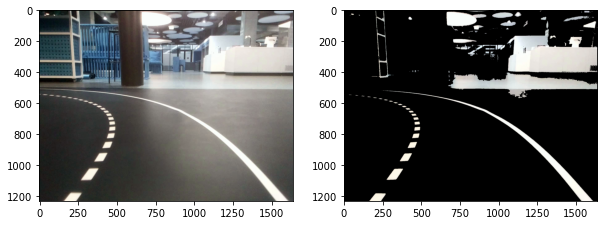

In [41]:
imgtup = processImage(col_images[idx])
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 8))
ax1.imshow(col_images[idx])
ax2.imshow(imgtup[0])


Preprocess
(1232, 1640)


Text(0.5, 1.0, 'canny')

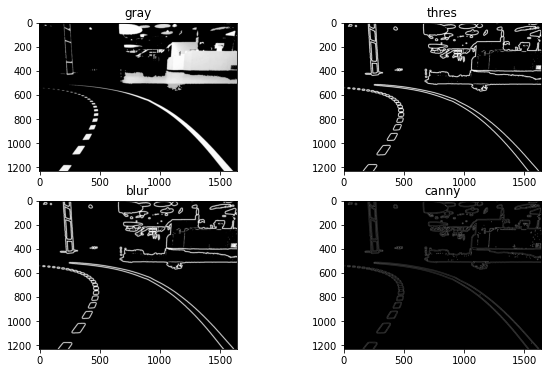

In [42]:
print("Preprocess")
print(imgtup[2].shape)
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(10, 6))
ax1.imshow(imgtup[1], cmap="gray")
ax1.set_title("gray")
ax2.imshow(imgtup[2], cmap="gray")
ax2.set_title("thres")
ax3.imshow(imgtup[3], cmap="gray")
ax3.set_title("blur")
ax4.imshow(imgtup[4], cmap="gray")
ax4.set_title("canny")


# How good is perspective wrapping ?

- Instead of cropping the image using roi func we try to create a birds eye view for the image using perspective wrap for the roi
- The bird's eye view is finally plotted

Notes: Even though wrapping and operating on the image might change the turn angle in some way we can adjust for this using a PID controller on the steering


In [43]:
# roi = [[90, 500],       [800, 500],       [200, 1200],       [1600, 1200]]
def perspectiveWarp(inpImage, luroi=0.25, ruroi=0.75, lbroi=0, rbroi=1, hroi=0.55):

    roi = [
        (luroi * ((inpImage.shape[1] - 1)), hroi * (inpImage.shape[0] - 1)),
        (ruroi * ((inpImage.shape[1] - 1)), hroi * (inpImage.shape[0] - 1)),
        (lbroi * ((inpImage.shape[1] - 1)), inpImage.shape[0] - 1),
        (rbroi * ((inpImage.shape[1] - 1)), inpImage.shape[0] - 1),
    ]
    # roi = [[90, 500],       [800, 500],       [200, 1200],       [1600, 1200]]
    print(roi)
    # Get image size
    img_size = (inpImage.shape[1], inpImage.shape[0])

    # Perspective points to be warped

    src = np.float32(roi)

    # Window to be shown
    dst = np.float32(
        [
            [0, 0],
            [inpImage.shape[1], 0],
            [0, inpImage.shape[0]],
            [inpImage.shape[1], inpImage.shape[0]],
        ]
    )

    # Matrix to warp the image for birdseye window
    matrix = cv2.getPerspectiveTransform(src, dst)
    # Inverse matrix to unwarp the image for final window
    minv = cv2.getPerspectiveTransform(dst, src)
    birdseye = cv2.warpPerspective(inpImage, matrix, img_size)

    # Get the birdseye window dimensions
    height, width = birdseye.shape[:2]

    # Divide the birdseye view into 2 halves to separate left & right lanes
    birdseyeLeft = birdseye[0:height, 0 : width // 2]
    birdseyeRight = birdseye[0:height, width // 2 : width]

    # Display birdseye view image
    # cv2.imshow("Birdseye" , birdseye)
    # cv2.imshow("Birdseye Left" , birdseyeLeft)
    # cv2.imshow("Birdseye Right", birdseyeRight)

    return birdseye, birdseyeLeft, birdseyeRight, minv


[(409.75, 677.0500000000001), (1229.25, 677.0500000000001), (0, 1231), (1639, 1231)]
Perspective wrapping: Define an roi and then perform perspective wrapping


Text(0.5, 1.0, 'birdeye_right')

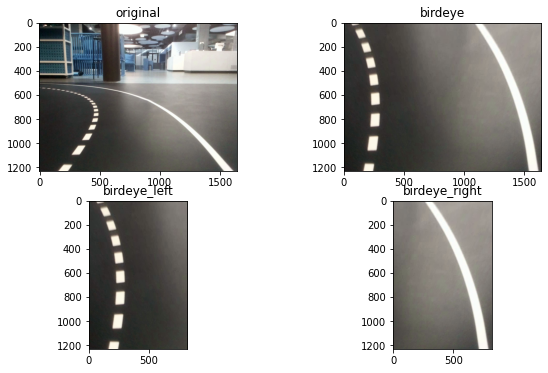

In [44]:
idx = 840
perspec = perspectiveWarp(col_images[idx])
print("Perspective wrapping: Define an roi and then perform perspective wrapping")
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(10, 6))
ax1.imshow(col_images[idx])
ax1.set_title("original")
ax2.imshow(perspec[0])
ax2.set_title("birdeye")
ax3.imshow(perspec[1])
ax3.set_title("birdeye_left")
ax4.imshow(perspec[2])
ax4.set_title("birdeye_right")


In [45]:
pres_processed = processImage(perspec[0])


Perspective Thresholding and Preprocess


Text(0.5, 1.0, 'canny')

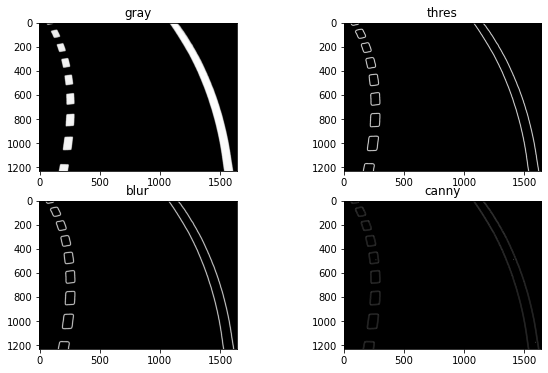

In [46]:
print("Perspective Thresholding and Preprocess")
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(10, 6))
ax1.imshow(pres_processed[1], cmap="gray")
ax1.set_title("gray")
ax2.imshow(pres_processed[2], cmap="gray")
ax2.set_title("thres")
ax3.imshow(pres_processed[3], cmap="gray")
ax3.set_title("blur")
ax4.imshow(pres_processed[4], cmap="gray")
ax4.set_title("canny")


# Sliding Window Search


Text(0.5, 1.0, 'Histogram of white pixes along x axis for all y')

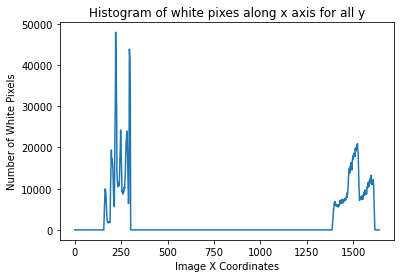

In [47]:
def image_hist(inpImage):

    histogram = np.sum(inpImage[inpImage.shape[0] // 2 :, :], axis=0)

    midpoint = int(histogram.shape[0] / 2)
    leftxBase = np.argmax(histogram[:midpoint])
    rightxBase = np.argmax(histogram[midpoint:]) + midpoint

    # Return histogram and x-coordinates of left & right lanes to calculate
    # lane width in pixels
    return histogram, leftxBase, rightxBase


hist, leftBase, rightBase = image_hist(pres_processed[2])
# print(rightBase - leftBase)
plt.plot(hist)
plt.xlabel("Image X Coordinates")
plt.ylabel("Number of White Pixels")
plt.title("Histogram of white pixes along x axis for all y")


In [48]:
def slide_window_search(binary_warped, histogram):

    # Find the start of left and right lane lines using histogram info
    out_img = np.dstack((binary_warped, binary_warped, binary_warped)) * 255
    midpoint = int(histogram.shape[0] / 2)
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint

    # A total of 10 windows will be used
    nwindows = 10
    window_height = int(binary_warped.shape[0] / nwindows)
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    leftx_current = leftx_base
    rightx_current = rightx_base
    margin = 150
    minpix = 50
    left_lane_inds = []
    right_lane_inds = []

    #### START - Loop to iterate through windows and search for lane lines #####
    for window in range(nwindows):
        win_y_low = binary_warped.shape[0] - (window + 1) * window_height
        win_y_high = binary_warped.shape[0] - window * window_height
        win_xleft_low = leftx_current - margin
        win_xleft_high = leftx_current + margin
        win_xright_low = rightx_current - margin
        win_xright_high = rightx_current + margin
        cv2.rectangle(
            out_img,
            (win_xleft_low, win_y_low),
            (win_xleft_high, win_y_high),
            (0, 255, 0),
            2,
        )
        cv2.rectangle(
            out_img,
            (win_xright_low, win_y_low),
            (win_xright_high, win_y_high),
            (0, 255, 0),
            2,
        )
        good_left_inds = (
            (nonzeroy >= win_y_low)
            & (nonzeroy < win_y_high)
            & (nonzerox >= win_xleft_low)
            & (nonzerox < win_xleft_high)
        ).nonzero()[0]
        good_right_inds = (
            (nonzeroy >= win_y_low)
            & (nonzeroy < win_y_high)
            & (nonzerox >= win_xright_low)
            & (nonzerox < win_xright_high)
        ).nonzero()[0]
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)
        if len(good_left_inds) > minpix:
            leftx_current = int(np.mean(nonzerox[good_left_inds]))
        if len(good_right_inds) > minpix:
            rightx_current = int(np.mean(nonzerox[good_right_inds]))

        # print(rightx_current)
    #### END - Loop to iterate through windows and search for lane lines #######

    left_lane_inds = np.concatenate(left_lane_inds)
    right_lane_inds = np.concatenate(right_lane_inds)

    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds]
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]

    plt.xlim(0, out_img.shape[1])
    plt.ylim(0, out_img.shape[0])

    ploty = np.linspace(0, binary_warped.shape[0] - 1, binary_warped.shape[0])
    # Apply 2nd degree polynomial fit to fit curves
    plt.gca().invert_yaxis()
    try:
        left_fit = np.polyfit(lefty, leftx, 1)
        left_fitx = left_fit[0] * ploty + left_fit[1]
        plt.plot(left_fitx, ploty, color="yellow")
    except:
        left_fit = np.array([])
        left_fitx = np.array([])
        # plt.plot(left_fitx,  ploty, color='yellow')
    try:
        right_fit = np.polyfit(righty, rightx, 1)
        right_fitx = right_fit[0] * ploty + right_fit[1]
        plt.plot(right_fitx, ploty, color="yellow")
    except:
        right_fit = np.array([])
        right_fitx = np.array([])
        # plt.plot(right_fitx, ploty, color='yellow')

    if left_fit.any():
        left_fit = right_fit
        left_fitx = right_fitx
    if right_fit.any():
        right_fit = left_fit
        right_fitx = left_fitx

    ltx = np.trunc(left_fitx)
    rtx = np.trunc(right_fitx)
    # plt.plot(right_fitx)
    # plt.show()

    out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
    out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]

    # plt.imshow(out_img)

    return ploty, left_fit, right_fit, ltx, rtx, out_img


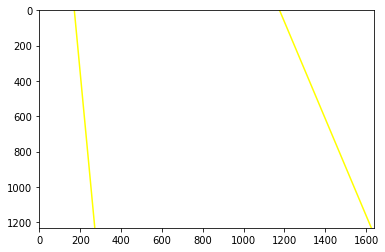

In [49]:
searchedplot = slide_window_search(pres_processed[2], hist)


[3.64552771e-01 1.17629638e+03] [3.64552771e-01 1.17629638e+03]


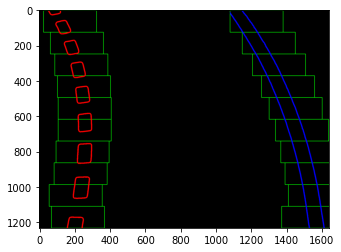

In [50]:
plt.imshow(searchedplot[5])
print(searchedplot[1], searchedplot[2])


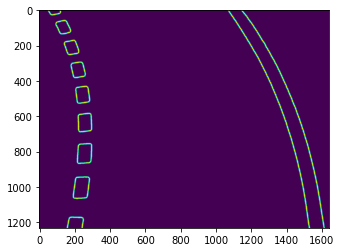

In [51]:
plt.imshow(pres_processed[2])


Slope of required line after coordinate system adjustment


In [52]:
print(
    "Slope line L: ",
    -1 / searchedplot[1][0],
    "\nSlope line R: ",
    -1 / searchedplot[2][0],
)


Slope line L:  -2.7430870884908076 
Slope line R:  -2.7430870884908076


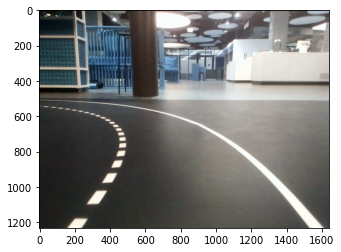

In [53]:
plt.imshow(col_images[idx])


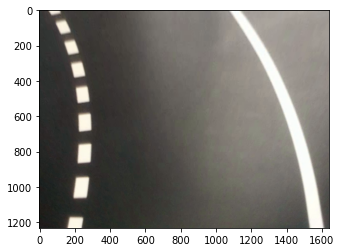

In [54]:
plt.imshow(perspec[0])


In [55]:
images_norm = processImage(col_images[idx])


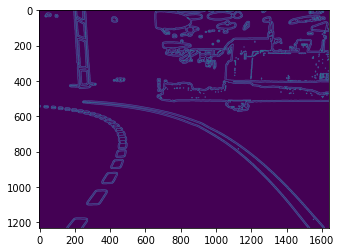

In [56]:
# Edges
plt.imshow(images_norm[4])


In [57]:
images_per = processImage(perspec[0])


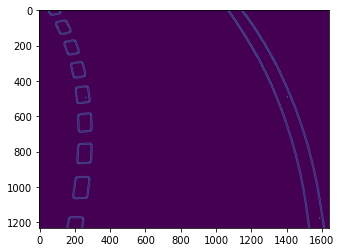

In [58]:
# Edges
plt.imshow(images_per[4])


## Hough Lines


In [59]:
from houghapproach import (
    roi_func,
    find_lanes,
    draw_line,
    average_slope_intercept,
    compute_steering_angle,
    display_heading_line,
    display_lines,
)


(1232, 1640, 3) (1232, 1640, 3)


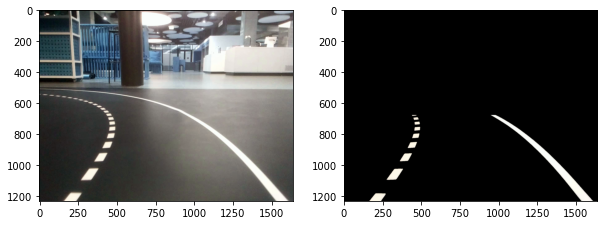

In [60]:
images_norm = processImage(col_images[idx])
roi_image_norm = roi_func(images_norm[0])
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 8))

ax1.imshow(col_images[idx])
ax2.imshow(roi_image_norm)


In [61]:
process_norm = processImage(roi_image_norm)


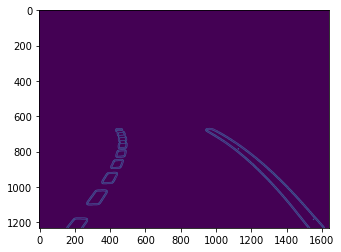

In [62]:
plt.imshow(process_norm[4])


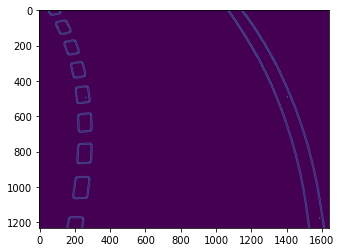

In [63]:
plt.imshow(images_per[4])


We have the Edge detected images for both birds eye view and current view (with masked roi). We next find the heading angle using hough lines and slope finding.


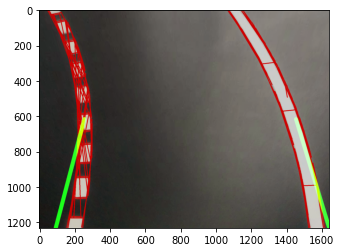

In [64]:
def make_points(frame, line):
    height, width, _ = frame.shape
    slope, intercept = line
    y1 = height  # bottom of the frame
    y2 = int(y1 * 1 / 2)  # make points from middle of the frame down

    # bound the coordinates within the frame

    if slope == 0:
        slope = 0.01
    x1 = max(-width, min(2 * width, int((y1 - intercept) / slope)))
    x2 = max(-width, min(2 * width, int((y2 - intercept) / slope)))
    return [[x1, y1, x2, y2]]


def average_slope_intercept(frame, line_segments):
    """
    This function combines line segments into one or two lane lines
    If all line slopes are < 0: then we only have detected left lane
    If all line slopes are > 0: then we only have detected right lane
    """
    lane_lines = []
    if line_segments is None:
        logging.info("No line_segment segments detected")
        return lane_lines

    height, width, _ = frame.shape
    left_fit = []
    right_fit = []

    boundary = 2 / 3
    # left lane line segment should be on left 2/3 of the screen
    left_region_boundary = width * (1 - boundary)
    # right lane line segment should be on left 2/3 of the screen
    right_region_boundary = width * boundary

    for line_segment in line_segments:
        for x1, y1, x2, y2 in line_segment:
            if x1 == x2:
                continue
            fit = np.polyfit((x1, x2), (y1, y2), 1)
            slope = fit[0]
            intercept = fit[1]
            if slope < 0:
                if x1 < left_region_boundary and x2 < left_region_boundary:
                    left_fit.append((slope, intercept))
            else:
                if x1 > right_region_boundary and x2 > right_region_boundary:
                    right_fit.append((slope, intercept))

    left_fit_average = np.average(left_fit, axis=0)
    if len(left_fit) > 0:
        lane_lines.append(make_points(frame, left_fit_average))

    right_fit_average = np.average(right_fit, axis=0)
    if len(right_fit) > 0:
        lane_lines.append(make_points(frame, right_fit_average))

    return lane_lines


lines = find_lanes(images_per[4])
plt.imshow(draw_line(perspec[0], lines))
lanelines = average_slope_intercept(perspec[0], lines)
plt.imshow(display_lines(perspec[0], lanelines, line_width=21))


In [65]:
compute_steering_angle(perspec[0][:, :, 0], lane_lines=lanelines)


91

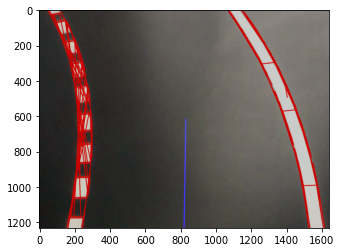

In [66]:
plt.imshow(
    display_heading_line(
        perspec[0], compute_steering_angle(perspec[0][:, :, 0], lane_lines=lanelines)
    )
)


[[[361, 1232, 521, 616]], [[1613, 1232, 1016, 616]]]


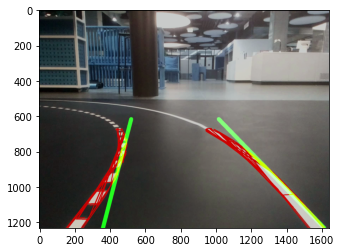

In [67]:
lines = find_lanes(process_norm[4])
plt.imshow(draw_line(col_images[idx], lines))
lanelines = average_slope_intercept(col_images[idx], lines)
print(lanelines)
plt.imshow(display_lines(col_images[idx], lanelines, line_width=21))


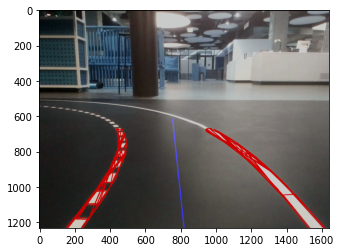

In [68]:
plt.imshow(
    display_heading_line(
        col_images[idx],
        compute_steering_angle(col_images[idx][:, :, 0], lane_lines=lanelines),
    )
)


In [69]:
compute_steering_angle(col_images[idx][:, :, 0], lane_lines=lanelines)


84

Birds eye view steering angle = 91

Normal view steering angle = 84
